In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/flood-area-segmentation/metadata.csv
/kaggle/input/flood-area-segmentation/Mask/1017.png
/kaggle/input/flood-area-segmentation/Mask/2015.png
/kaggle/input/flood-area-segmentation/Mask/1084.png
/kaggle/input/flood-area-segmentation/Mask/2021.png
/kaggle/input/flood-area-segmentation/Mask/1012.png
/kaggle/input/flood-area-segmentation/Mask/48.png
/kaggle/input/flood-area-segmentation/Mask/3012.png
/kaggle/input/flood-area-segmentation/Mask/1037.png
/kaggle/input/flood-area-segmentation/Mask/2009.png
/kaggle/input/flood-area-segmentation/Mask/1023.png
/kaggle/input/flood-area-segmentation/Mask/3070.png
/kaggle/input/flood-area-segmentation/Mask/37.png
/kaggle/input/flood-area-segmentation/Mask/1048.png
/kaggle/input/flood-area-segmentation/Mask/3068.png
/kaggle/input/flood-area-segmentation/Mask/1000.png
/kaggle/input/flood-area-segmentation/Mask/35.png
/kaggle/input/flood-area-segmentation/Mask/2030.png
/kaggle/input/flood-area-segmentation/Mask/1081.png
/kaggle/input/flood

In [5]:
import numpy as np 
import pandas as pd 
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend as K
from keras.callbacks import LearningRateScheduler, ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras.utils import load_img, array_to_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import random
import os
from tqdm.notebook import tqdm
from PIL import Image

%matplotlib inline

from colorama import Style, Fore
blk = Style.BRIGHT + Fore.BLACK
red = Style.BRIGHT + Fore.RED
blu = Style.BRIGHT + Fore.BLUE
res = Style.RESET_ALL

# Data Preparation

In [6]:
base_dir = '/kaggle/input/flood-area-segmentation'
images_dir = f'{base_dir}/Image' 
masks_dir = f'{base_dir}/Mask' 

In [7]:
img_path= os.listdir(images_dir)
mask_path= os.listdir(masks_dir)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(sorted(img_path), sorted(mask_path), test_size=0.2, random_state=24)
img_size = 256

In [9]:
def load_img(path):
    img = Image.open(path)
    if img is None:
        raise ValueError(f"Empty Image at {path}")
    img = img.convert("RGB")
    return img

def load_data(path_list, gray=False, img_size=256):
    data = []
    for path in tqdm(path_list):
        img = load_img(path)
        if gray:
            img = img.convert("L")
        img = img.resize((img_size, img_size))
        img_array = np.array(img)
        if gray:
            img_array = img_array.reshape((img_size, img_size, 1))
        data.append(img_array)
    return np.array(data)

In [10]:
X_train= load_data([images_dir +"/"+ x for x in X_train])
X_test= load_data([images_dir +"/"+ x for x in X_test])

  0%|          | 0/232 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

In [11]:
Y_train= load_data([masks_dir + '/' + x for x in y_train], gray=True)/255.0
Y_test= load_data([masks_dir + '/' + x for x in y_test], gray=True)/255.0
Y_train= Y_train.reshape(-1, img_size, img_size, 1)
Y_test= Y_test.reshape(-1, img_size, img_size, 1)

  0%|          | 0/232 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

In [12]:
print(f"{blk}===( Train )===")
print(f"{blk}Images shape : {red}{X_train.shape}")
print(f"{blk}Masks shape : {red}{Y_train.shape}")

print(f"{blk}===( Test )===")
print(f"{blk}Images shape : {red}{X_test.shape}")
print(f"{blk}Masks shape : {red}{Y_test.shape}")

===( Train )===
Images shape : (232, 256, 256, 3)
Masks shape : (232, 256, 256, 1)
===( Test )===
Images shape : (58, 256, 256, 3)
Masks shape : (58, 256, 256, 1)


# Build Model

In [13]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, Concatenate
from tensorflow.keras.models import Model
# Define the U-Net model architecture
def unet_model(input_size, filters):
    inputs = Input(input_size)
    x = inputs
    layers = []

    # Downward path
    for i in range(1, 7):
        x = Conv2D(filters * i, 3, activation='relu', padding='same')(x)
        x = Conv2D(filters * i, 3, activation='relu', padding='same')(x)
        layers.append(x)
        x = MaxPooling2D()(x)

    # Bottleneck
    x = Conv2D(filters * 7, 3, activation='relu', padding='same')(x)
    x = Conv2D(filters * 7, 3, activation='relu', padding='same')(x)

    # Upward path
    for i in range(6, 0, -1):
        x = Conv2DTranspose(filters * i, 2, strides=(2, 2), padding='same')(x)
        x = Concatenate(axis=3)([x, layers[i - 1]])
        x = Conv2D(filters * i, 3, activation='relu', padding='same')(x)
        x = Conv2D(filters * i, 3, activation='relu', padding='same')(x)

    # Output layer
    outputs = Conv2D(1, 1, activation='sigmoid')(x)

    # Model compilation
    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [14]:
# Initialize the U-Net model
model = unet_model((img_size, img_size, 3), filters=8)

# Training the model
batch_size = 32
epochs = 30
# Train the model on the training data
history = model.fit(
    X_train, Y_train,
    validation_data=(X_test, Y_test),
    batch_size=batch_size,
    epochs=epochs,
    verbose=1)

Epoch 1/30
8/8 [==============================] - 34s 4s/step - loss: 2.3746 - accuracy: 0.5040 - val_loss: 1.2291 - val_accuracy: 0.5622
Epoch 2/30
8/8 [==============================] - 28s 4s/step - loss: 1.2013 - accuracy: 0.5191 - val_loss: 1.1056 - val_accuracy: 0.5234
Epoch 3/30
8/8 [==============================] - 29s 4s/step - loss: 0.8923 - accuracy: 0.5616 - val_loss: 0.7702 - val_accuracy: 0.6198
Epoch 4/30
8/8 [==============================] - 29s 4s/step - loss: 0.7275 - accuracy: 0.6488 - val_loss: 0.6746 - val_accuracy: 0.6776
Epoch 5/30
8/8 [==============================] - 28s 3s/step - loss: 0.6139 - accuracy: 0.7135 - val_loss: 0.5441 - val_accuracy: 0.7486
Epoch 6/30
8/8 [==============================] - 28s 4s/step - loss: 0.5722 - accuracy: 0.7414 - val_loss: 0.5350 - val_accuracy: 0.7524
Epoch 7/30
8/8 [==============================] - 27s 3s/step - loss: 0.5289 - accuracy: 0.7605 - val_loss: 0.5128 - val_accuracy: 0.7640
Epoch 8/30
8/8 [==================

In [15]:
# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(X_test, Y_test, verbose=1)
print(f"Test accuracy: {test_accuracy:.4f}, Test loss: {test_loss:.4f}")

2/2 [==============================] - 2s 644ms/step - loss: 0.3666 - accuracy: 0.8277
Test accuracy: 0.8277, Test loss: 0.3666


In [16]:
unet_predict = model.predict(X_test)

2/2 [==============================] - 2s 664ms/step


In [17]:
predict_tresh = (unet_predict > 0.5).astype(np.uint8)

In [18]:
def show_result(og, pred, target):
    fig, axs = plt.subplots(1, 3, figsize=(10,5))
    axs[0].set_title("Original")
    axs[0].imshow(og)
    axs[0].axis('off')
    
    axs[1].set_title("Predict")
    axs[1].imshow(pred)
    axs[1].axis('off')
    
    axs[2].set_title("Target")
    axs[2].imshow(target)
    axs[2].axis('off')

    plt.show()

In [19]:
show_test_idx = random.sample(range(len(X_test)), 5)

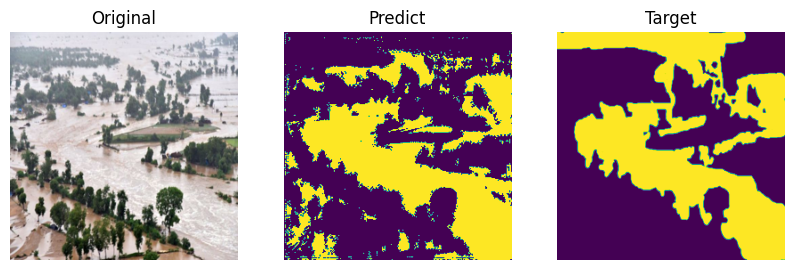

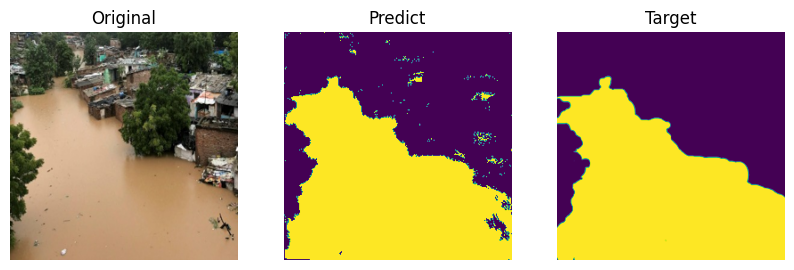

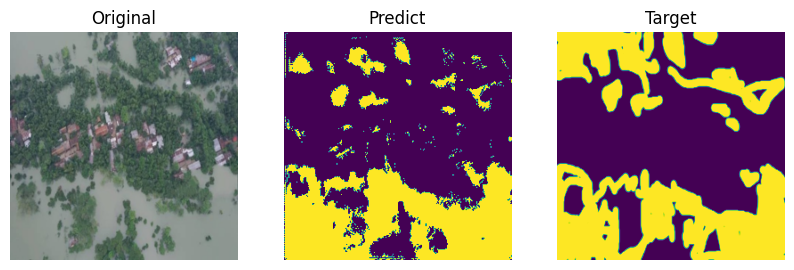

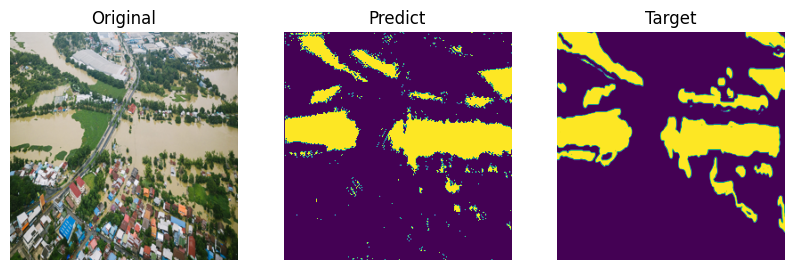

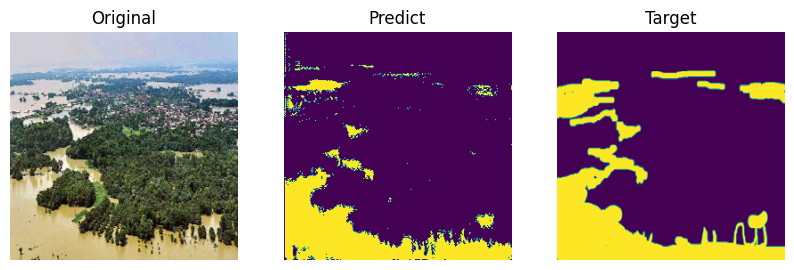

In [20]:
for idx in show_test_idx: 
    show_result(X_test[idx], predict_tresh[idx], Y_test[idx])